In [1]:
import torch
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from data_loader import get_dataloader
from models.dual_model import DualModel
from metrics import find_optimal_threshold_for_ace

In [2]:
INTRA = True
YEAR = '2015'
SENSOR = 'CrossMatch'
DATASET_PATH = '/home/hmb1604/datasets/LivDet'
BINARY_CLASS = True

BATCH_SIZE = 8
NUM_WORKERS = 4

LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 1

MODEL_SAVED_PATH = './ckpts/model.pth'
os.makedirs('./ckpts', exist_ok=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = {
    'Train': T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomAffine(
            degrees=(-20, 20),          # Rotation
            translate=(0.2, 0.2),       # Horizontal/vertical shift
            shear=(-20, 20),            # Shear
            scale=(0.8, 1.2),           # Zoom
            interpolation=T.InterpolationMode.NEAREST,
            fill=0
        ),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),

    'Test': T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

In [4]:
train_loader, val_loader, train_label_map = get_dataloader(intra=INTRA, year=YEAR, sensor=SENSOR, dataset_path=DATASET_PATH, train=True, binary_class=BINARY_CLASS, transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader, test_label_map = get_dataloader(intra=INTRA, year=YEAR, sensor=SENSOR, dataset_path=DATASET_PATH, train=False, binary_class=BINARY_CLASS, transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

Loading Test Ecoflex: 100%|██████████| 270/270 [00:00<00:00, 58362.30it/s]


In [5]:
model = DualModel(num_classes=1).to(device=device)
model = torch.nn.DataParallel(model)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

In [10]:
history = {
    'train_losses': [],
    'val_losses': [],
    'best_val_loss': 1e3,
}

In [11]:
print('Begin training...')

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0.0
    
    for idx, (imgs, labels) in tqdm(enumerate(train_loader), desc=f"train epoch [{epoch+1}/{NUM_EPOCHS}]"):
        imgs, labels = imgs.to(device), labels.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs.squeeze(1), labels)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_losses'].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"val epoch [{epoch+1}/{NUM_EPOCHS}]"):
            imgs, labels = imgs.to(device), labels.to(device, dtype=torch.float)
            
            outputs = model(imgs)
            loss = criterion(outputs.squeeze(1), labels)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    history['val_losses'].append(avg_val_loss)

    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss [{avg_train_loss:.4f}] Val Loss: [{avg_val_loss:.4f}]')

    if avg_val_loss < history['best_val_loss']:
        history['best_val_loss'] = avg_val_loss
        torch.save(model.state_dict(), MODEL_SAVED_PATH)
        print(f'Model saved!')

print('Finish training...')

Begin training...


train epoch [1/1] batch [299/299]: 299it [02:55,  1.71it/s]
val epoch [1/1] batch [299/299]: 100%|██████████| 75/75 [00:13<00:00,  5.44it/s]


Epoch [1/1] Train Loss [0.4036] Val Loss: [0.2183]
Model saved!
Finish training...


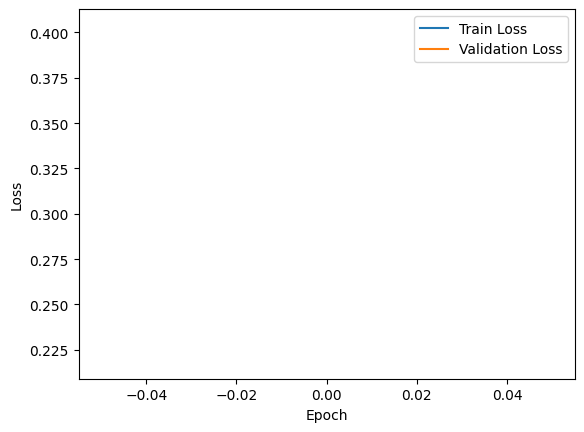

In [12]:
# Plot losses
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.load_state_dict(torch.load(MODEL_SAVED_PATH))

# Testing phase
model.eval()
all_targets = []
all_probabilities = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device, dtype=torch.float)
        
        outputs = model(data)
        probabilities = torch.sigmoid(outputs.squeeze(1))
        
        all_targets.extend(targets.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

targets = np.array(all_targets).astype(int)
probabilities = np.array(all_probabilities)

In [14]:
threshold, apcer, bpcer, accuracy, ace, acc = find_optimal_threshold_for_ace(targets, probabilities)
print(f"APCER: {apcer*100:.2f}%")
print(f"BPCER: {bpcer*100:.2f}%")
print(f"ACE:   {ace*100:.2f}%")
print(f"Acc*:  {acc*100:.2f}%")
print(f"Acc:   {accuracy*100:.2f}%")

APCER: 7.87%
BPCER: 17.27%
ACE:   12.57%
Acc*:  87.43%
Acc:   87.35%
